# Singal To Noise All Models
 - Calculates the singal to nosie for all models in longrunmip for GMST
 - Fraction of models stable for windows for GMST
 
 PHD-9:
 * read_and_merge_netcdfs moved from longrunmip_loader to open_ds


In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from importlib import reload
import matplotlib.ticker as mticker
import os, sys
import constants
sys.path.append(constants.MODULE_DIR)
import sn_plotting as sn_plot
import xarray_class_accessors as xca
import open_ds
import signal_to_noise as sn
import xarray_extender as xce
import utils
from classes import ExperimentTypes
import xarray_extender
warnings.filterwarnings('ignore')
logger = utils.get_notebook_logger()

In [2]:
from multiprocessing import Pool
from functools import partial

In [3]:
VARIABLE_INFO = constants.VARIABLE_INFO
VARIABLE_INFO

{'tas': {'longname': 'Near-surface air temperature', 'units': '$^{\\circ}C$'},
 'pr': {'longname': 'Precipitation', 'units': 'mm\\year'},
 'netTOA': {'longname': 'Net TOA flux'},
 'sic': {'longname': 'Sea Ice Area Fraction', 'units': 'fraction'},
 'psl': {'longname': 'Sea level pressure'},
 'tos': {'longname': 'Sea surface temperature', 'units': '$^{\\circ}C$'},
 'surf': {'longname': 'Neat Ocean Heat Uptake'}}

In [4]:
notebook_number='draft'
variable = 'tas'
ROOT_DIR = os.path.join(constants.LONGRUNMIP_DIR, variable, 'regrid_retimestamped')
ROOT_DIR

'/g/data/w40/ab2313/PhD/longrunmip/tas/regrid_retimestamped'

# Loading Data

In [5]:
models_to_get = open_ds.get_models_longer_than_length()
utils.pprint_list(models_to_get, num_start_items=7)

lenght = 7
 0. ccsm3
 1. cesm104
 2. cnrmcm61
 3. hadcm3l
 4. ipslcm5a
 5. mpiesm11
 6. mpiesm12


In [6]:
files_to_open_experiment = open_ds.get_file_names_from_from_directory(ROOT_DIR,
                                                           ExperimentTypes.ABRUPT4X,
                                                           models_to_get)

files_to_open_control = open_ds.get_file_names_from_from_directory(ROOT_DIR,
                                                           ExperimentTypes.CONTROL,
                                                           models_to_get)
utils.pprint_list(files_to_open_experiment, num_start_items=5)

lenght = 7
 0. tas_mon_CCSM3_abrupt4x_2120_g025.nc
 1. tas_mon_CESM104_abrupt4x_5900_g025.nc
 2. tas_mon_CNRMCM61_abrupt4x_1850_g025.nc
 3. tas_mon_HadCM3L_abrupt4x_1000_g025.nc
 4. tas_mon_IPSLCM5A_abrupt4x_1000_g025.nc


In [7]:
reload(open_ds)
control_ds = open_ds.read_and_merge_netcdfs(files_to_open_control, ROOT_DIR)#, mask='sea')
abrupt4x_ds = open_ds.read_and_merge_netcdfs(files_to_open_experiment, ROOT_DIR)#, mask='sea')
abrupt4x_ds

Removing first 10 steps for tas_mon_CCSM3_control_1530_g025.nc


<xarray.Dataset>
Dimensions:   (time: 1200, lon: 144, lat: 72)
Coordinates:
  * time      (time) object 0001-12-31 00:00:00 ... 1200-12-31 00:00:00
  * lon       (lon) float32 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat       (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
    height    float64 ...
Data variables:
    ccsm3     (time, lat, lon) float32 -36.44 -36.81 -36.81 ... -2.414 -2.413
    cesm104   (time, lat, lon) float32 -42.74 -42.83 -42.9 ... -4.047 -4.015
    cnrmcm61  (time, lat, lon) float32 -47.32 -47.32 -47.33 ... 4.162 4.18 4.18
    hadcm3l   (time, lat, lon) float64 -43.95 -44.02 -43.9 ... nan nan nan
    ipslcm5a  (time, lat, lon) float32 -42.89 -43.01 -43.13 ... nan nan nan
    mpiesm11  (time, lat, lon) float32 -47.93 -47.92 -47.89 ... 1.017 1.015
    mpiesm12  (time, lat, lon) float32 -48.58 -48.6 -48.65 ... nan nan nan
Attributes:
    length:   2120

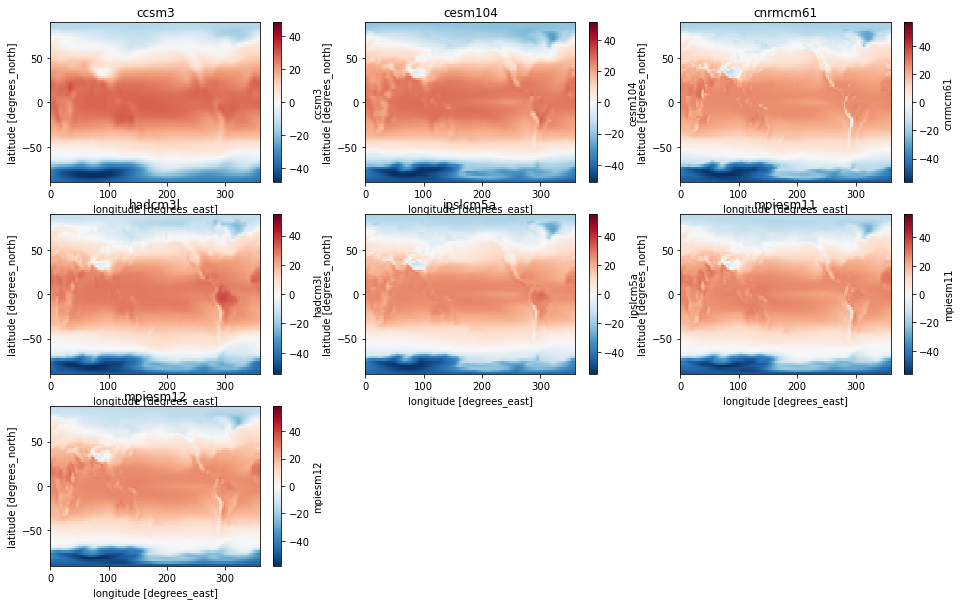

In [8]:
models = list(abrupt4x_ds.data_vars)
num_cols = 3
num_rows = int(np.ceil(len(models)/num_cols))

fig = plt.figure(figsize=(16,10))

for i,model in enumerate(models):
    ax = fig.add_subplot(num_rows, num_cols, i+1)
    
    abrupt4x_ds[model].isel(time=0).plot(ax=ax)
    ax.set_title(model)
    
    ax.set_title(model)

In [73]:
abrupt4x_mean,control_ds_mean = sn.calculate_global_value(abrupt4x_ds, control_ds, variable)

ccsm3, cesm104, cnrmcm61, hadcm3l, ipslcm5a, mpiesm11, mpiesm12, 

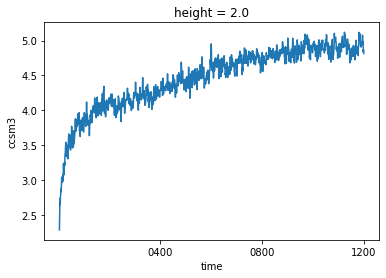

In [76]:
abrupt4x_mean['ccsm3'].plot()

In [111]:
sn_da = sn.calculate_rolling_signal_to_noise(da=abrupt4x_mean['ccsm3'], window=33, logginglevel='ERROR')

33, 

<xarray.DataArray 'signal_to_noise' (window: 1, time: 1168)>
array([[7.5329597 , 8.87917886, 8.50443399, ..., 1.68380265, 1.20443124,
        0.84545213]])
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 1168-12-31 00:00:00
    height   float64 2.0
  * window   (window) int64 33

In [50]:
%%time
sn_muliwindow_da = sn.calculate_multi_window_signal_to_noise(
    abrupt4x_mean['ccsm3'], start_window =31, end_window = 200, step_window = 2, 
    parallel=True)

35, 47, 55, 59, 83, 71, 75, 63, 87, 67, 51, 79, 43, 31, 39, 91, 37, 49, 33, 95, 99, 103, 97, 101, 105, 107, 111, 115, 109, 113, 45, 65, 81, 77, 57, 85, 73, 61, 69, 41, 53, 89, 93, 117, 119, 123, 127, 121, 125, 129, 131, 135, 139, 133, 143, 147, 151, 159, 155, 163, 141, 137, 167, 171, 179, 175, 183, 187, 191, 195, 199, 189, 177, 173, 193, 145, 153, 149, 157, 165, 161, 169, 181, 185, 197, CPU times: user 1.57 s, sys: 542 ms, total: 2.11 s
Wall time: 30.3 s


In [51]:
%%time
sn_muliwindow_control_da = sn.calculate_multi_window_signal_to_noise(
    control_ds_mean['ccsm3'], lowess_filter=False, start_window =31, end_window = 200, step_window = 2, 
    parallel=True)

39, 31, 35, 55, 47, 43, 59, 63, 51, 67, 75, 71, 79, 91, 87, 83, 41, 37, 61, 53, 65, 69, 77, 73, 45, 49, 33, 57, 89, 93, 85, 81, 95, 99, 103, 107, 115, 111, 119, 123, 97, 101, 105, 127, 131, 109, 121, 117, 113, 135, 139, 143, 151, 125, 147, 155, 159, 163, 167, 175, 171, 183, 179, 187, 129, 133, 145, 137, 141, 157, 149, 153, 161, 165, 169, 177, 173, 181, 185, 189, 191, 195, 199, 193, 197, CPU times: user 1.69 s, sys: 544 ms, total: 2.23 s
Wall time: 17.8 s


In [52]:
lbound, ubound = sn.calculate_upper_and_lower_bounds(sn_muliwindow_control_da)

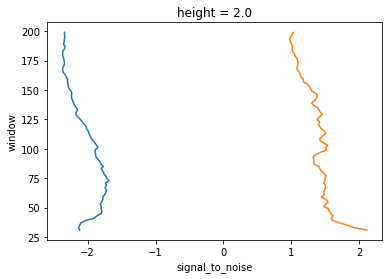

In [81]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
lbound.plot(ax=ax1, y='window', label='lower bound')
ubound.plot(ax=ax1, y='window', label='upper bound')

In [54]:
%%time
sn_multi_window_ds = sn.calculate_rolling_signal_to_nosie_and_bounds(
                    abrupt4x_mean['ccsm3'], control_ds_mean['ccsm3'],
                    start_window = 21, end_window = 221, step_window = 8, parallel=True)
sn_multi_window_ds

21, 37, 29, 45, 53, 77, 61, 69, 85, 101, 117, 133, 141, 125, 93, 109, 149, 157, 165, 173, 181, 189, 197, 205, 213, 21, 45, 93, 85, 109, 125, 77, 69, 141, 61, 117, 133, 29, 101, 37, 53, 149, 157, 165, 181, 173, 189, 197, 205, 213, CPU times: user 1.48 s, sys: 845 ms, total: 2.33 s
Wall time: 15.2 s


<xarray.Dataset>
Dimensions:          (time: 1180, window: 25)
Coordinates:
  * time             (time) object 0001-12-31 00:00:00 ... 1180-12-31 00:00:00
    height           float64 2.0
  * window           (window) int64 21 29 37 45 53 61 ... 181 189 197 205 213
Data variables:
    signal_to_noise  (window, time) float64 6.006 7.872 8.128 ... nan nan nan
    lower_bound      (window) float64 -2.551 -2.311 -2.139 ... -0.3479 -0.3819
    upper_bound      (window) float64 3.003 3.033 2.962 ... 3.069 3.041 3.004

In [55]:
%%time
unstable_sn_multi_window_da , stable_sn_multi_window_da =\
        sn.sn_multi_window(abrupt4x_mean['ccsm3'], control_ds_mean['ccsm3'], parallel=True)

25, 21, 27, 33, 23, 29, 35, 31, 39, 43, 37, 41, 45, 47, 49, 51, 53, 55, 59, 57, 21, 29, 23, 25, 27, 31, 33, 35, 37, 41, 39, 43, 45, 47, 49, 51, 53, 55, 57, 59, CPU times: user 1.29 s, sys: 777 ms, total: 2.07 s
Wall time: 13 s


In [57]:
RUN_PARAMS = dict(end_window = 370)# 370 is standard
RUN_PARAMS['end_window']

370

In [63]:
%%time
stable_sn_ds, unstable_sn_ds= abrupt4x_mean[['ccsm3']].sn_ds.sn_multiwindow(control_ds_mean[['ccsm3']],
                 end_window=RUN_PARAMS['end_window'], step_window=2, parallel=True)

ccsm3
20, 98, 74, 44, 38, 80, 56, 104, 92, 62, 26, 32, 68, 50, 86, 22, 110, 24, 34, 46, 88, 106, 82, 94, 116, 58, 40, 28, 52, 64, 70, 76, 100, 112, 36, 48, 90, 96, 108, 84, 122, 128, 134, 140, 146, 152, 118, 60, 42, 30, 78, 102, 54, 66, 72, 114, 124, 130, 136, 154, 148, 142, 158, 120, 164, 170, 176, 182, 188, 194, 206, 200, 126, 132, 138, 150, 156, 144, 160, 166, 172, 212, 178, 184, 190, 196, 202, 208, 218, 224, 230, 236, 242, 248, 162, 220, 226, 232, 238, 244, 250, 254, 168, 174, 180, 214, 186, 192, 198, 204, 210, 222, 234, 228, 240, 246, 252, 256, 260, 266, 272, 216, 284, 290, 278, 296, 302, 308, 314, 258, 320, 326, 332, 338, 262, 268, 274, 286, 298, 310, 344, 350, 280, 304, 292, 316, 328, 322, 340, 334, 264, 276, 270, 288, 300, 312, 346, 352, 282, 294, 306, 330, 318, 324, 342, 336, 356, 362, 368, 348, 354, 358, 364, 360, 366, 26, 44, 20, 62, 38, 32, 92, 86, 28, 68, 104, 74, 110, 80, 98, 56, 30, 50, 116, 52, 46, 70, 88, 22, 40, 100, 64, 106, 58, 76, 34, 82, 94, 112, 48, 54, 72, 90, 1

In [64]:
%%time
stable_sn_ds, unstable_sn_ds= abrupt4x_mean[['ccsm3']].sn_ds.sn_multiwindow(control_ds_mean[['ccsm3']],
                 end_window=RUN_PARAMS['end_window'], step_window=2, parallel=False)

ccsm3
20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98,

In [65]:
number_models_present = sn.count_over_data_vars(abrupt4x_mean, list(unstable_sn_ds.data_vars), dim='model')

unstable_number_da = sn.number_finite(unstable_sn_ds)
stable_number_da = sn.number_finite(stable_sn_ds)

unstable_number_da

<xarray.DataArray (window: 175, time: 1182)>
array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]])
Coordinates:
  * time     (time) object 0001-12-31 00:00:00 ... 1182-12-31 00:00:00
    height   float64 2.0
  * window   (window) int64 20 22 24 26 28 30 32 ... 356 358 360 362 364 366 368